## Next Task: compute precision and recall

threshold 25: zoomy, sustain->thick,  smooth    (user results)  
zoomy, sustain  -> dark, smooth             (word2word matcher resuts)  
smooth tp   
dark fp  
thik tn (fn?) 

precision = tp/(tp+fp)  
recall = tp/(tp+fn)  

for one word, cant compute recall  
later: tensorflow language models, Optimising (Kullback-Leibler) for the distribution

In [1]:
import sys
import ipdb
import pandas as pd
import numpy as np
from tqdm import tqdm
sys.path.append(r'C:\Temp\SoundOfAI\rg_text_to_sound\tts_pipeline\src')

from match_word_to_words import prepare_dataset,word_to_wordpair_estimator,word_to_words_matcher,prepare_dataset
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('text_to_qualities.csv')
colnames = df.columns
display(df.head(2))
df.shape

,bright_vs_dark,full_vs_hollow,smooth_vs_rough,warm_vs_metallic,clear_vs_muddy,thin_vs_thick,pure_vs_noisy,rich_vs_sparse,soft_vs_hard,description
0,63,25,60,75,11,66,93,19,50,sitar-like
1,68,29,71,22,31,76,35,29,50,Full


(1303, 10)

In [3]:
dfnew = prepare_dataset(df)
dfnew[dfnew.description.str.match('\'')]
dfnew['description'] = dfnew.description.str.replace("'","")
dfnew['description']=dfnew.description.str.lower().str.replace('(\(not.*\))','',regex=True)
dfnew = dfnew[~dfnew.description.str.match('\(.*\)')]
dfnew.head()

,description,bright_vs_dark,full_vs_hollow,smooth_vs_rough,warm_vs_metallic,clear_vs_muddy,thin_vs_thick,pure_vs_noisy,rich_vs_sparse,soft_vs_hard
0,reversed,59.0,74.0,42.0,44.0,75.0,69.0,60.0,85.0,58.0
3,acoustic,47.0,12.5,69.0,42.0,42.0,59.5,45.0,27.0,12.0
4,aggressive,20.0,50.0,99.0,84.0,77.0,77.0,79.0,23.0,79.0
5,artificial,50.0,50.0,99.0,70.0,50.0,50.0,76.0,50.0,50.0
6,biting,23.0,46.0,36.0,29.0,58.0,50.0,63.5,42.0,72.5


In [4]:
wordlist = dfnew.description
unique_word_list = np.unique(wordlist).tolist()
len(wordlist),len(unique_word_list)

(668, 626)

threshold 25: zoomy, sustain->thick,  smooth    (user results)  
zoomy, sustain  -> dark, smooth             (word2word matcher resuts)  
smooth tp   
dark fp  
thik tn  

precision = tp/(tp+fp)  
recall = tp/(tp+fn)  

for one word, cant compute recall

# word pair estimator

In [5]:
df_score = dfnew.iloc[:,1:]

descriptions = dfnew.iloc[:,0]
wordpairnames = df_score.columns.tolist()
df_score.head()

,bright_vs_dark,full_vs_hollow,smooth_vs_rough,warm_vs_metallic,clear_vs_muddy,thin_vs_thick,pure_vs_noisy,rich_vs_sparse,soft_vs_hard
0,59.0,74.0,42.0,44.0,75.0,69.0,60.0,85.0,58.0
3,47.0,12.5,69.0,42.0,42.0,59.5,45.0,27.0,12.0
4,20.0,50.0,99.0,84.0,77.0,77.0,79.0,23.0,79.0
5,50.0,50.0,99.0,70.0,50.0,50.0,76.0,50.0,50.0
6,23.0,46.0,36.0,29.0,58.0,50.0,63.5,42.0,72.5


In [6]:
target_word_pairs = [('bright', 'dark'), ('full', 'hollow'),( 'smooth', 'rough'), ('warm', 'metallic'), ('clear', 'muddy'), ('thin', 'thick'), ('pure', 'noisy'), ('rich', 'sparse'), ('soft', 'hard')]
wordpairnames_to_wordpair_dict = {s:t for s,t in zip(wordpairnames,target_word_pairs)}
wordpairnames_to_wordpair_dict

{'bright_vs_dark': ('bright', 'dark'),
 'full_vs_hollow': ('full', 'hollow'),
 'smooth_vs_rough': ('smooth', 'rough'),
 'warm_vs_metallic': ('warm', 'metallic'),
 'clear_vs_muddy': ('clear', 'muddy'),
 'thin_vs_thick': ('thin', 'thick'),
 'pure_vs_noisy': ('pure', 'noisy'),
 'rich_vs_sparse': ('rich', 'sparse'),
 'soft_vs_hard': ('soft', 'hard')}

In [7]:
list(np.arange(49.8,50,0.1))
A=set([1,2,3])
B=set([3,4,5])
AandB = A.intersection(B)

B.difference(AandB)

{4, 5}

In [8]:
def single_word_precision_recall(word,scorerow,threshold,w2wpe,wordpairnames_to_wordpair_dict):
    elems_above = scorerow[(scorerow>(100-threshold)) ]
    elems_below = scorerow[(scorerow<=threshold) ]
    words_above = [wordpairnames_to_wordpair_dict[wordpairname][1] for wordpairname in elems_above.index]
    words_below = [wordpairnames_to_wordpair_dict[wordpairname][0] for wordpairname in elems_below.index]
    A = set(words_above+words_below)
    opposite_pairs_beyond_threshold = elems_above.index.tolist()+elems_below.index.tolist()
    B = set([w2wpe.match_word_to_wordpair(word,ind)['closest word'] for ind in opposite_pairs_beyond_threshold])
    assert len(A)==len(B), 'This should never occurr!'
    
    AandB = set(A).intersection(B)
    tp = AandB
    fp = B.difference(AandB) # were found but shouldn't have been
    fn = A.difference(AandB) # were not found but should have been

    den = len(tp)+len(fp)
    if den==0:
        precision = np.NaN
    else:
        precision = len(tp)/den

    den = len(tp)+len(fn)
    if den==0:
        recall = np.NaN
    else:
        recall = len(tp)/den
    
    if precision!=recall and not np.isnan(precision): 
        print('This should never occur!')
        print('word, A,B,AandB,tp,fp,fn,precision,recall')
        print(word, A,B,AandB,tp,fp,fn,precision,recall)
    return precision,recall,len(A)

In [9]:
lang_model='en_core_web_sm'
w2wpe = word_to_wordpair_estimator()
w2wpe.build(wordpairnames,target_word_pairs,lang_model=lang_model)
w2wpe.match_word_to_wordpair('full','full_vs_hollow')

{'proximity': 0.0,
 'slider value': 0.0,
 'closest dist': 0.0,
 'other dist': 6.304089796156789,
 'closest word': 'full',
 'other word': 'hollow'}

In [10]:
word = descriptions[0]
scorerow = df_score.iloc[0,:]
prec_50_list=[]
NrRelevantWordpairList=[]
for word, (irow,scorerow) in tqdm(zip(descriptions, df_score.iterrows())):
    prec,rec,NrRelevantWordpairs = single_word_precision_recall(word,scorerow,10,w2wpe,wordpairnames_to_wordpair_dict)
    prec_50_list.append(prec)
    NrRelevantWordpairList.append(NrRelevantWordpairs)

668it [00:03, 184.66it/s]


In [11]:
pd.Series(prec_50_list).dropna()

2      1.000000
3      0.000000
5      0.000000
12     0.000000
17     0.000000
         ...   
656    0.750000
657    0.333333
658    1.000000
664    1.000000
666    0.666667
Length: 272, dtype: float64

In [12]:


len(prec_50_list),np.mean(prec_50_list)

(668, nan)

In [13]:

' '.join([f'{i:1.1f}' for i in thresholdlist])

'0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 26.0 28.0 30.0 32.0 34.0 36.0 38.0 40.0 42.0 44.0 46.0 48.0 45.0 45.5 46.0 46.5 47.0 47.5 48.0 48.5 49.0 49.5 50.0'

In [32]:
def compute_accuracy(lang_model='en_core_web_lg'):
    w2wpe = word_to_wordpair_estimator()
    w2wpe.build(wordpairnames,target_word_pairs,lang_model=lang_model)
    thresholdlist = list(np.arange(0,50,2))+list(np.arange(45,50,0.5))+[50.]

    mean_accuracy_list = []
    nrrelevantlist = []
    for threshold in tqdm(thresholdlist):
        acc_list=[]
        NrRelevantWordpairList=[]
        for word, (irow,scorerow) in zip(descriptions, df_score.iterrows()):
            precision,recall,NrRelevantWordpairs = single_word_precision_recall(word,scorerow,threshold,w2wpe,wordpairnames_to_wordpair_dict)
            acc_list.append(precision)
            NrRelevantWordpairList.append(NrRelevantWordpairs)
        assert len(acc_list)>0, 'something is wrong...'
        meanAccuracyVal = pd.Series(acc_list).dropna().mean()
        NrRelevantVal = np.mean(NrRelevantWordpairList)

        mean_accuracy_list.append(meanAccuracyVal)
        nrrelevantlist.append(NrRelevantVal)
    return mean_accuracy_list,nrrelevantlist

In [33]:
%time
lang_model1 = 'en_core_web_sm'
lang_model2 = 'en_core_web_lg'
mean_accuracy_list1,nrrelevantlist1 = compute_accuracy(lang_model=lang_model1)
mean_accuracy_list2,nrrelevantlist2 = compute_accuracy(lang_model=lang_model2)

Wall time: 0 ns


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [11:05<00:00, 18.49s/it]


In [41]:
if np.all(np.isclose(np.array(nrrelevantlist1),np.array(nrrelevantlist2))):
    nrrelevantlist = nrrelevantlist1

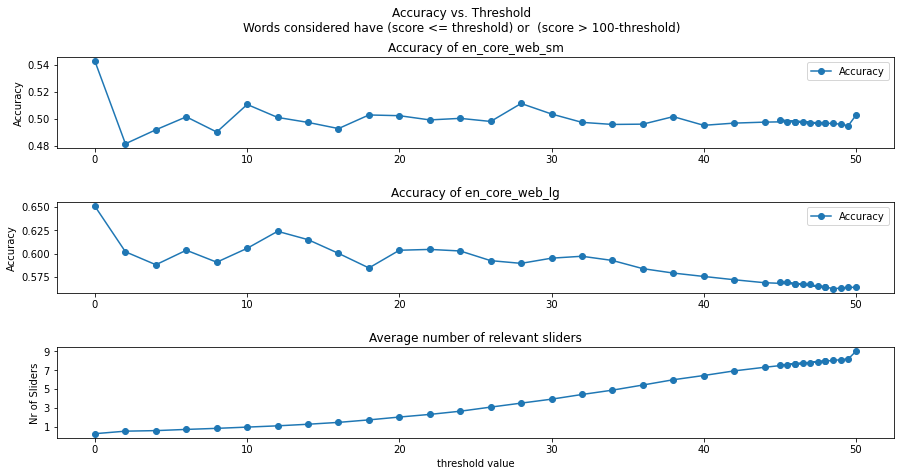

In [50]:
plt.figure(1,figsize=(15,7))
plt.subplot(3,1,1)
plt.plot(thresholdlist,mean_accuracy_list1,marker='o',label='Accuracy')
plt.suptitle(f'Accuracy vs. Threshold\nWords considered have (score <= threshold) or  (score > 100-threshold)')
plt.title(f'Accuracy of {lang_model1}')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,1,2)
plt.plot(thresholdlist,mean_accuracy_list2,marker='o',label='Accuracy')
plt.title(f'Accuracy of {lang_model2}')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3,1,3)
plt.plot(thresholdlist,nrrelevantlist,marker='o')
plt.title('Average number of relevant sliders')
plt.xlabel('threshold value')
plt.ylabel('Nr of Sliders')
plt.yticks(np.arange(1,10,2))
plt.subplots_adjust(hspace=.6)

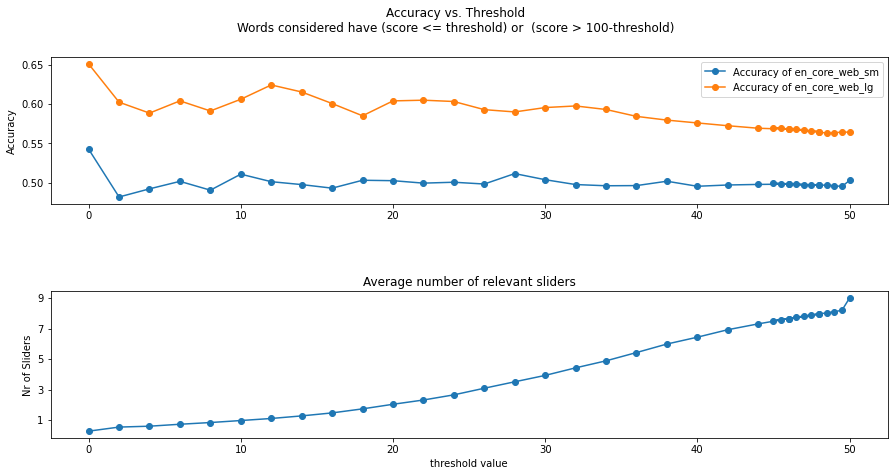

In [51]:
plt.figure(1,figsize=(15,7))
plt.subplot(2,1,1)
plt.plot(thresholdlist,mean_accuracy_list1,marker='o',label=f'Accuracy of {lang_model1}')
plt.plot(thresholdlist,mean_accuracy_list2,marker='o',label=f'Accuracy of {lang_model2}')
plt.suptitle(f'Accuracy vs. Threshold\nWords considered have (score <= threshold) or  (score > 100-threshold)')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,1,2)

plt.plot(thresholdlist,nrrelevantlist,marker='o')
plt.title('Average number of relevant sliders')
plt.xlabel('threshold value')
plt.ylabel('Nr of Sliders')
plt.yticks(np.arange(1,10,2))
plt.subplots_adjust(hspace=.6)

In [ ]:
row
lang_model = 'en_core_web_sm'

w2wpe = word_to_wordpair_estimator()
w2wpe.build(wordpairnames,target_word_pairs,lang_model=lang_model)
prediction_dict = w2wpe.match_word_to_wordpair(word,ind)
ind,prediction_dict[]

In [ ]:
ind,w2wpe.match_word_to_wordpair(word,ind)

In [ ]:

def compute_mean_acc(dfnew,df_score,thresholdmargin,threshold=50, required_confidence=0, lang_model='en_core_web_sm'):
    """
    Take the opposite quality pairs for which the slider value is outside the 50+/- <thresholdmargin> band. 
    Compute the accuracy in predicting the correct opposite-pair word for each such pair. 
    threshold: where to split a score to lower or upper quality in pair: 50 is the most natural value.
    The prediction must be with a (minimum) < required_confidence > otherwise the prediction is deemed unsure.
    The returned accuracy is computed as 
    accuracy = NrCorrect/(NrCorrect+NrWrong+NrUnsure)
    averaged over all words in <dfnew>.description
    """
    
    w2wpe = word_to_wordpair_estimator()
    w2wpe.build(wordpairnames,target_word_pairs,lang_model=lang_model)
    acc_list = []
    unsure_list = []
    NrCorrect = 0
    NrWrong = 0
    NrUnsure = 0
    for word, (irow,scorerow) in zip(dfnew.description, df_score.iterrows()):
        #determine which opposite quality pairs will be correctly predicted as the first and second word in the word pair, respectively
        valid_qualities = scorerow[(scorerow > threshold+thresholdmargin )|(scorerow < threshold-thresholdmargin)]
        
        below_th = valid_qualities[valid_qualities<threshold].index.tolist()#first word in the word pair is correct
        above_th = valid_qualities[valid_qualities>threshold].index.tolist()#second word in the word pair is correct
        
        #word_pair_tuple = wordpairnames_to_wordpair_dict[word_pair]
        
        
        NrCorrect = 0
        NrWrong = 0
        NrUnsure = 0
        for word_pair in above_th:
            res = w2wpe.match_word_to_wordpair(word,word_pair)            
            if res['slider value']>(threshold+required_confidence):# Add prediction threshold?
                NrCorrect+=1
            elif res['slider value']<(threshold-required_confidence):
                NrWrong+=1            
            else:
                NrUnsure+=1 #if required confidence was not reached
        for word_pair in below_th:
            res = w2wpe.match_word_to_wordpair(word,word_pair)            
            if res['slider value']<(threshold-required_confidence):# Add prediction threshold?
                NrCorrect+=1
            elif res['slider value']>threshold+required_confidence:
                NrWrong+=1
            else:
                NrUnsure+=1 #if required confidence was not reached
        if len(below_th)+len(above_th)==0: continue
        accuracy = NrCorrect/(NrCorrect+NrWrong+NrUnsure)
        unsure_ratio = NrUnsure/(NrCorrect+NrWrong+NrUnsure)  # the fraction of cases where the prediction did not reach the required confidence
        acc_list.append(accuracy)
        unsure_list.append(unsure_ratio)
        #resdict = {'NrCorrect':NrCorrect, 'NrWrong':NrWrong, 'NrUnsure':NrUnsure}
    mean_acc = np.mean(acc_list) #list of accuracies for each word, over all available sliders
    mean_unsure = np.mean(unsure_list)
    del w2wpe
    return mean_acc,mean_unsure

In [ ]:
def f():
    ipdb.set_trace()
    return wordpair_matcher_dict['bright_vs_dark'].match_word_to_words('sunny')
f()

In [ ]:
y = np.array([np.where(row['bright_vs_dark']>=50,1,0) for row in rowlist])
y.shape,yhat1.shape

In [ ]:
yhat_binary = np.array([0 if yhatelem==target_word_pair[0] else 1 for yhatelem in yhat1])
yhat_binary.shape

In [ ]:
len(yhat),len(rowlist)

In [ ]:
accuracy_score(y,yhat_binary)

In [ ]:
yhat1

In [ ]:
df_detailed = pd.DataFrame(index=wordlist)
df_detailed.head(7)

In [ ]:
wordlist = [w for r,w in generate_training_examples(df)]
rowlist =  [r for r,w in generate_training_examples(df)]

acc_scores=dict()
for target_word_pair,opposite_quality_pair in zip(target_word_pairs,colnames):
    y = np.array([np.where(row[opposite_quality_pair]>=50,1,0) for row in rowlist])
    
    print(target_word_pair,opposite_quality_pair)
    w2wm = word_to_words_matcher()
    w2wm.build(target_word_pair)
    yhat1 = np.array(f(wordlist,w2wm,variant=1))
    df_detailed[opposite_quality_pair] = yhat1
    yhat_binary = np.array([0 if yhatelem==target_word_pair[0] else 1 for yhatelem in yhat1])
    acc_score = accuracy_score(y,yhat_binary)
    print(f'{acc_score:1.3f}')
    acc_scores[opposite_quality_pair] = acc_score

In [ ]:
print(df_detailed.shape)
df_detailed.to_excel('predicted_qualities.xlsx')
df_detailed.head(20)

In [ ]:
pd.Series(acc_scores).plot.bar(ylabel='accuracy')
plt.plot(plt.xlim(),[0.5,0.5],'--',c='k')
plt.title(f'Accuracy of Spacy word vectors in predicting\ntext_to_qualities.csv ({len(wordlist)} qualities)')
plt.ylim(0,1)

## Next Task: compute precision and recall

threshold 25: zoomy, sustain->thick,  smooth    (user results)  
zoomy, sustain  -> dark, smooth             (word2word matcher resuts)  
smooth tp   
dark fp  
thik tn  

precision = tp/(tp+fp)  
recall = tp/(tp+fn)  

for one word, cant compute recall  
later: tensorflow language models, Optimising (Kullback-Leibler) for the distribution